# Data Details

**MV104 police reported crash database**

MV104 reports are filled out by NYPD officers responding to a crash. The reports are sent to the state DMV who compiles the data into a database. It is then sent to the state DOT who geocodes the crash location and sends it to NYC DOT.

* Three tables: Crash table, Person table, and Vehicle table, linked by common identifiers.
* NY State DMV has the three tables ([crash](https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Case-Information-Three-Year-/e8ky-4vqe), [person](https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Individual-Information-Three/ir4y-sesj), [vehicle](https://data.ny.gov/Transportation/Motor-Vehicle-Crashes-Vehicle-Information-Three-Ye/xe9x-a24f)) on NY Open Data, but does not include the common identifiers needed to link the datasets together.

Before 2017 NYPD used paper reports. In 2017 they switched over to an electronic system called FORMS. This allows them maintain their own database of information instead of having to rely on the state. 

![Data Flow](img/MV104DataFlow.jpg)

**Hospital records data**
* Hospital administrative records were obtained from NY SPARCS (Statewide Planning and Research Cooperative System).
* Time period: 2011 - 2013 (Billing code changes prior to 2011 made using earlier data infeasible. Post 2013 hospital data was not available at the time.)
* Injury Severity Score derived from patient records using the Barell matrix formula. (b-ISS). 

DOHMH used the hospital administrative data on each patient to determine an injury severity score using the [Barell Matrix method](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2564435/) .  The Barell Matrix is a classification system to translate billing codes into a matrix of injury types. These groupings are given an [Abbreviated Injury Scale (AIS) code](https://en.wikipedia.org/wiki/Abbreviated_Injury_Scale) ranging from 1 to 6 ( from minor injury to death).  Patients have an AIS for each injury, these are combined into one overall [Injury Severity Score (ISS)](https://en.wikipedia.org/wiki/Injury_Severity_Score) by taking the top three AIS from different body regions, squaring them and summing.

**Linked Police Reports and Hospital data**

In 2017 DOHMH linked police crash report data with hospital data. [Reference: Conderino, S, Fung, L  et al. “Linkage of traffic crash and hospitalization records with limited identifiers for enhanced public health surveillance” AA&P 2017.] About half the hospitalizations and ER visits related to traffic crashes were able to be matched to an MV104 crash report. They used a probabilistic matching method based on person level attributes (age, sex, crash role, collision type, date and time of crash, injury type, injury body location, and county). The time period was 2011 - 2013 (Billing code changes prior to 2011 made using earlier data infeasible. Post 2013 hospital data was not available at the time.)


![DataVenn](img/DataVenn.jpg)

This gave us a valuable dataset to start our analysis. The rest of this notebook explores the data in the linked dataset as well as the larger crash database. 

<span style="color:red"> Faraz's comment below on removing the sys path. </span>

In [3]:
import pandas as pd
pd.options.display.max_rows = 130
pd.options.display.max_columns = 130

import numpy as np

import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

import databuild as db
import sys
sys.path.insert(0,'/home/deena/Documents/data_munge/ModaCode/') # Faraz's comment: comment this out so that it doesn't appear on Github. Also comment this out from other .ipynb files in this folder.
import moda

In [4]:
# read in DMV data into 3 tables
crash,ind,veh = db.readDMV()

# reorganize into pedestrian/bicyclist 1-veh crashes
ped = db.buildTablesDMV(crash,ind,veh)

#read in DMV-SPARCS linked data
linked = db.readLinked()

# included biss data from linked onto ped (dropping anything not in linked)
ped = db.mergeBiss(ped,linked)

#format and categorize variables
ped = db.formatVars(ped)

print 'linked ped',ped.shape

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


full crash table (522108, 26)
full person table (1502797, 22)
full vehicle table (1092922, 20)


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (1,9,20,25,35,48,54,58,63,65,85,89,102,126,128,129,138) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


pedestrians/bicyclists (police reported) (single vehicle) (95292, 80)
linked (76763, 131)
linked after dropping no police reports (69657, 131)
linked ped (17624, 106)


Here's a sample of what's in the three DMV tables:

In [5]:
crash.head()

,CS_ID,NYSACCT_ID,CSACCTIME,CSACCDTE,ACCDAY,HR1,MIN1,LGHTCNDT_ID,MUNIT_ID,CLSNMNRT_ID,CS_CNTYT_ID,RDSYST_ID,RDCHART_ID,WTHRT_ID,TFCCTRLT_ID,RDSRFT_ID,CS_REF_MARKER,PBLOCT_ID,PBACTT_DMV_CDE,EVNTT_ID,VEH_CNT,POL_REPT,year,day,month,date
0,32049967,3,1899-12-30 18:45:00.000,2007-01-05 00:00:00.000,6,18,45,-1,1118,4,42,4,-1,-1,-1,-1,None,-2,-2,1,2,N,2007,05,01,2007-01-05
1,32049979,4,1899-12-30 13:00:00.000,2007-01-05 00:00:00.000,6,13,0,1,637,1,25,4,1,3,-1,2,None,-2,-2,1,2,N,2007,05,01,2007-01-05
2,32049982,4,1899-12-30 06:45:00.000,2007-01-09 00:00:00.000,3,6,45,-1,637,-1,25,4,-1,-1,-1,-1,None,-2,-2,1,2,N,2007,09,01,2007-01-09
3,32049985,4,1899-12-30 09:45:00.000,2007-01-09 00:00:00.000,3,9,45,-1,637,-1,25,4,1,1,1,1,None,-2,-2,1,2,N,2007,09,01,2007-01-09
4,32049988,3,1899-12-30 18:20:00.000,2007-01-10 00:00:00.000,4,18,20,4,1141,1,44,10,2,1,1,1,278IX6M13018,-2,-2,1,2,Y,2007,10,01,2007-01-10


In [6]:
veh.head()

,CS_ID,CV_ID,VEHBDYT_ID,REGT_CDE,PACCACTT_ID,TBCT_DMV_CDE,DIRCTT_CDE,FT_ID,CV_VEH_YEAR,CV_REG_STATE_CDE,CV_WEIGHT_LBS,CV_PSGR_NUM,CV_CYLNDR,CV_VEHMAKE_DESCR,CFT_CDE1,CFT_CDE2,SHZMTT_ID,VEH_EVNTT_ID,VIN,DMV_VIN_NUM
0,32045885,5979599,6.0,16,-1,-3,-1,1,1998,NY,None,-1,4,TOYOT,None,None,None,None,2T1BR12E2WC,None
1,32045886,5979600,6.0,-3,3,-3,-1,-3,None,SC,None,3,None,None,None,None,None,None,None,None
2,32045886,5979601,5.0,16,1,-3,-1,1,1999,NY,None,2,6,DODGE,None,None,None,None,2B4FP2532XR,None
3,32045887,5979602,60.0,56,1,-3,-1,2,2002,NY,None,-1,8,GMC,None,None,None,None,1GDJG31F821,None
4,32045887,5979603,15.0,-3,1,-3,-1,-3,None,OK,None,1,None,None,None,None,None,None,None,None


In [7]:
ind.head()

,CS_ID,CI_ID,CV_ID,EMTNSTATT_CDE,CIROLET_ID,STPSTNT_ID,EJCTT_ID,CI_LICENSE_STATE_CDE,CI_SEX_CDE,SFTYEQPT_ID,SEVERITY,INDIV_AGE,EMST_CDE,INJT_ID,INJLOCT_CDE,HOSP,ORG_HOSP_CDE,LAGSTP,LAGSEV,LAGEMS,LAGINJT,LAGHOSP
0,32088863,30431,6059995,None,15,1,None,None,None,None,O,NaN,None,None,None,None,None,None,.,.,None,None
1,32089687,30443,6061752,None,15,1,None,None,None,None,O,NaN,None,None,None,None,None,None,.,.,None,None
2,32089986,30447,6062247,None,15,1,None,None,None,None,O,NaN,None,None,None,None,None,None,.,.,None,None
3,32090042,30448,6062336,None,15,1,None,None,None,None,O,NaN,None,None,None,None,None,None,.,.,None,None
4,32090124,30449,6062468,None,15,1,None,None,None,None,O,NaN,None,None,None,None,None,None,.,.,None,None


In [1]:
crash.date.min(),crash.date.max()

NameError: name 'crash' is not defined

<span style="color:red"> Faraz's comment: What do the INJT_ID numbers 16, 17 and 18 represent? Write out. </span>

In [4]:
# police reported crashes
crashPR = crash[crash.POL_REPT=='Y']
indPR = ind[ind.CS_ID.isin(crashPR.CS_ID)&(~ind.INJT_ID.isin(['16','17','18']))]
crashPR = crashPR[crashPR.CS_ID.isin(indPR.CS_ID)]

print crash.shape
print crashPR.shape

(522108, 26)
(371958, 26)


## Police Reported Crashes - number per day

<span style="color:red"> Faraz's comment: not sure what this graph is telling/showing. The denominator needs to be a little less granular e.g. the number of police reported crashes per month for the purpose of readability. There are other graphs in this notebook that also have a lot of spikes that make them harder to read/understand. </span>

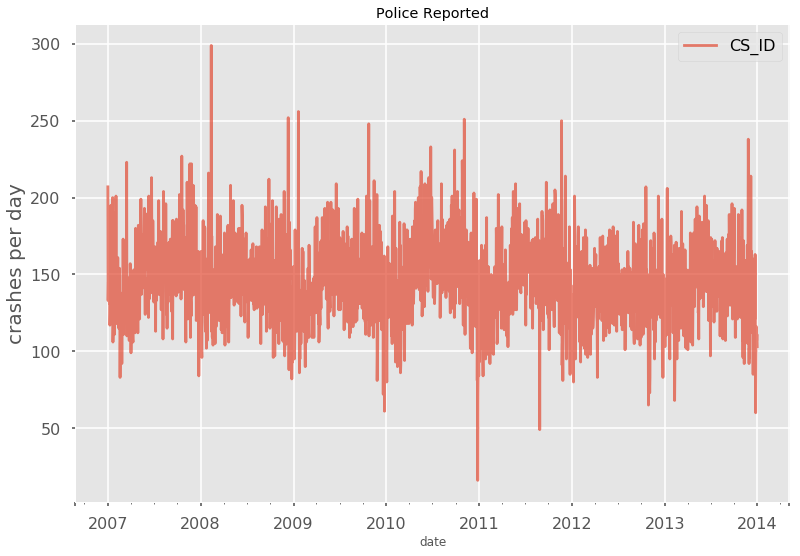

In [5]:
# police reported crashes
crashPR.groupby('date').count()[['CS_ID']].plot(alpha=.7)
plt.ylabel('crashes per day',fontsize=20)
plt.title('Police Reported')

<span style="color:red"> General comments on data viz: the x-axis title and y-axis title should have the same font size. The header should have a slightly larger font size. </span>

## People involved in police reported crashes
* by role
* by injury severity (KABCO)

In [6]:
# format the variables for easier analysis
base = indPR.merge(crash.drop(['RDSYST_ID'],axis=1),
                      how='left',on='CS_ID')
base = db.formatVars(base)


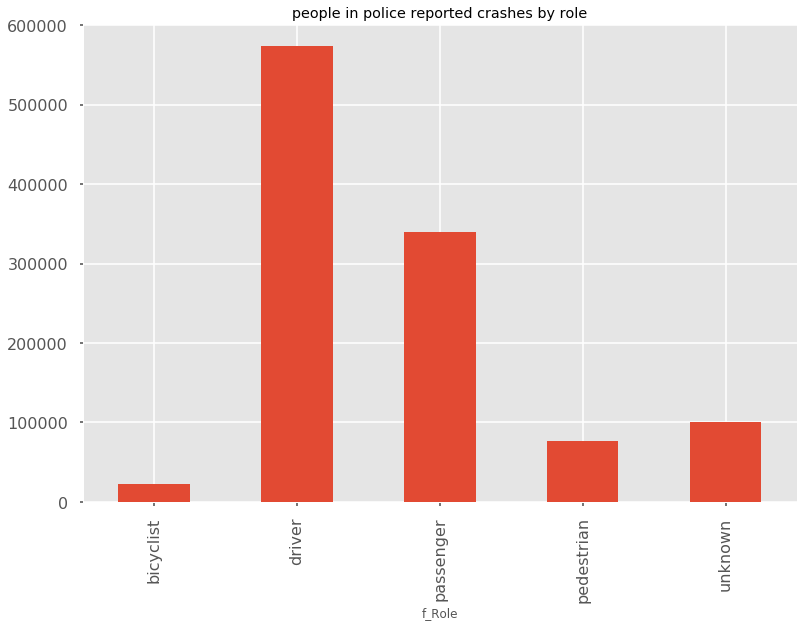

In [7]:
base.groupby(base.f_Role).count()[['CS_ID']].plot(kind='bar',legend=False)
plt.title('people in police reported crashes by role')

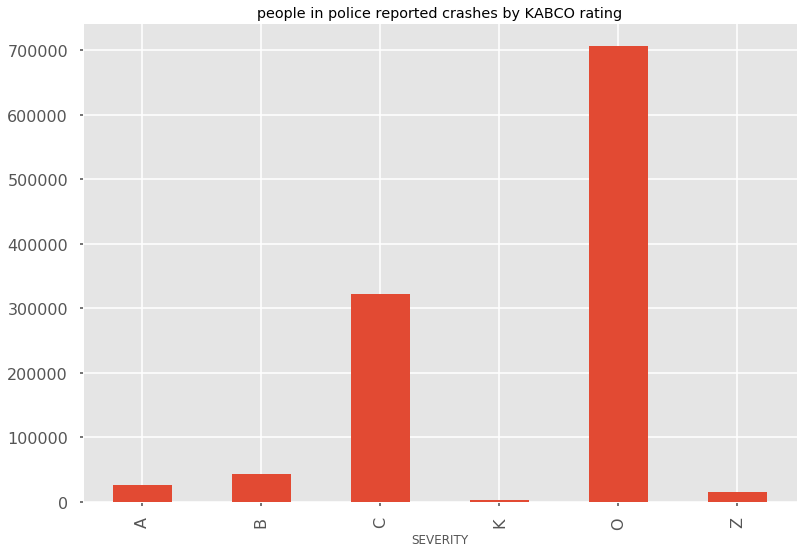

In [8]:
base.groupby(base.SEVERITY).count()[['CS_ID']].plot(kind='bar',legend=False)
plt.title('people in police reported crashes by KABCO rating')

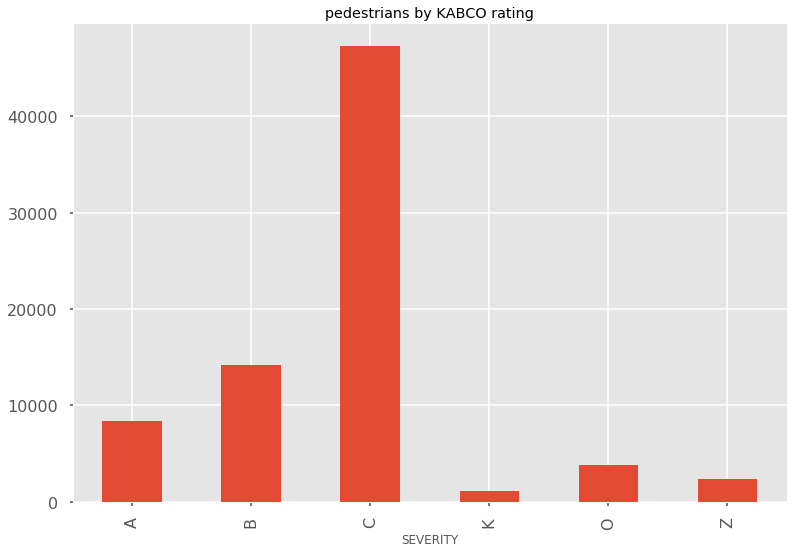

In [9]:
base[base.f_Role=='pedestrian'].groupby(base.SEVERITY).count()[['CS_ID']]\
    .plot(kind='bar',legend=False)
plt.title('pedestrians by KABCO rating')

<span style="color:red"> Faraz's comment: Top one or two findings of this section? </span>

## Fatal or Severely injured  (K,A) people 
* per day
* per year

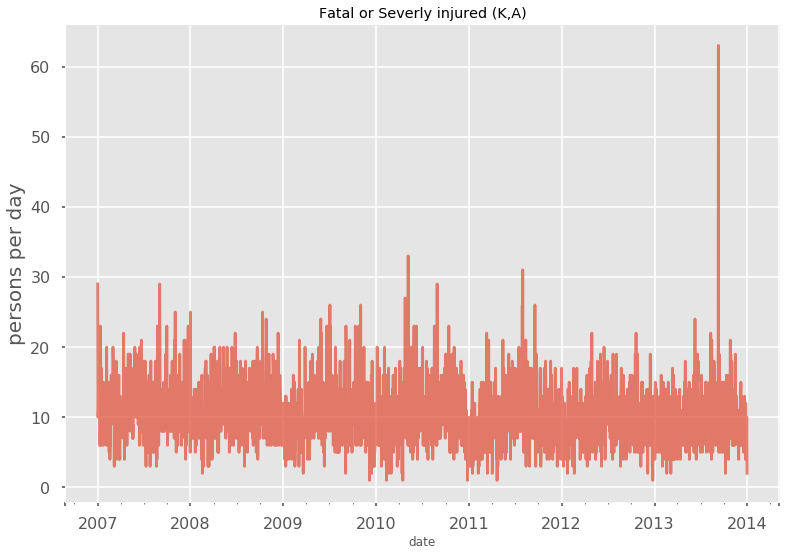

In [10]:
# number of severely injured people per day
sevInjPer = base[base.SEVERITY.isin(['K','A'])]
sevInjPer.groupby('date').count()[['CS_ID']].plot(alpha=.7,legend=False)
plt.ylabel('persons per day',fontsize=20)
plt.title('Fatal or Severly injured (K,A)')

<span style="color:red"> Faraz's comment: Why is there a big uptick of K,A cases in late 2013? </span>

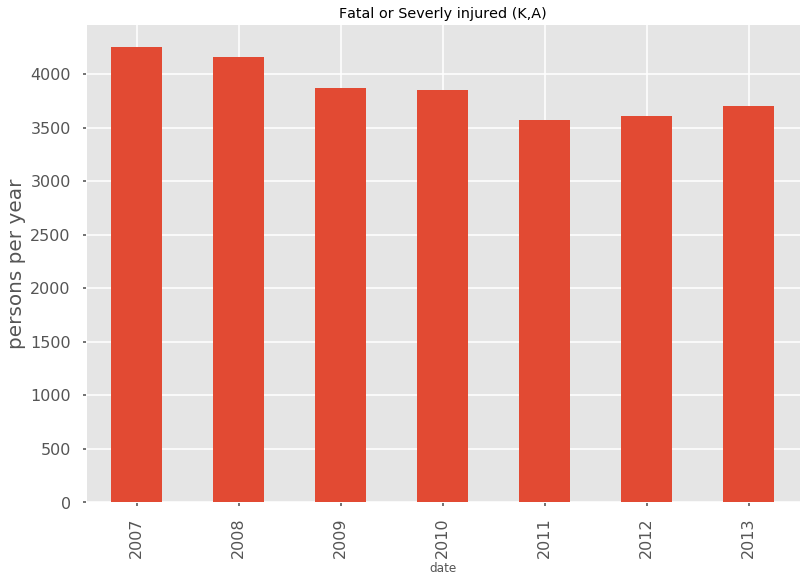

In [11]:
sevInjPer.groupby(sevInjPer.date.dt.year).count()[['CS_ID']].plot(kind='bar',
                                                                  legend=False)
plt.ylabel('persons per year',fontsize=20)
plt.title('Fatal or Severly injured (K,A)')

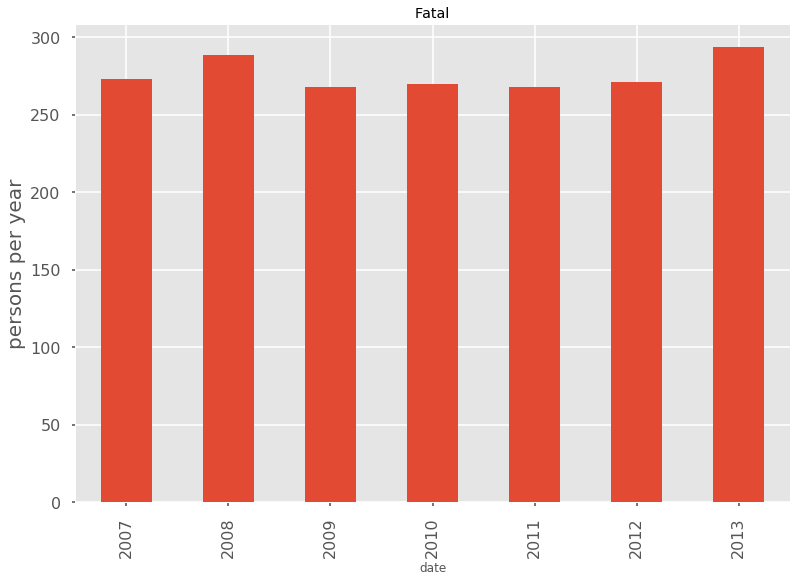

In [12]:
# number of fatalities per day
fatal = base[base.SEVERITY.isin(['K'])]
fatal.groupby(fatal.date.dt.year).count()[['CS_ID']].plot(kind='bar',legend=False)
plt.ylabel('persons per year',fontsize=20)
plt.title('Fatal')

## Pedestrians: Fatal or Severely injured (K,A)
* per day
* per year

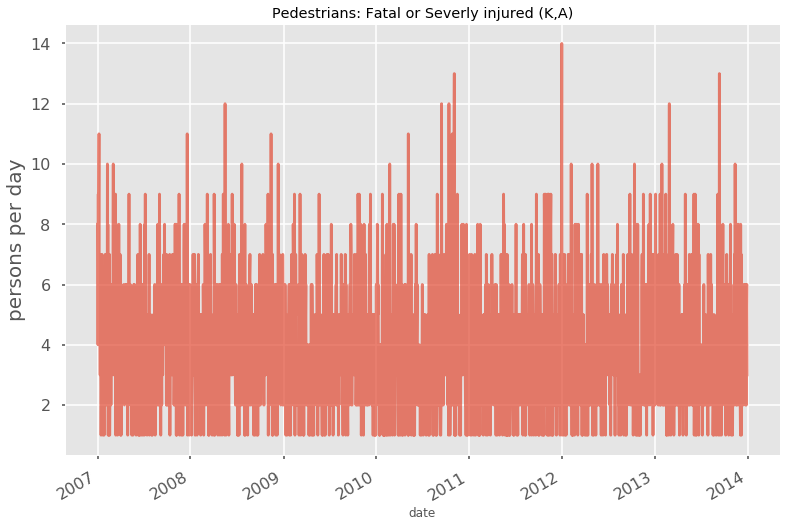

In [13]:
# number of severely injured pedestrians per day
sevInjPed = base[(base.SEVERITY.isin(['K','A']))&(base.f_Role=='pedestrian')]
sevInjPed.groupby('date').count()[['CS_ID']].plot(alpha=.7,legend=False)
plt.ylabel('persons per day',fontsize=20)
plt.title('Pedestrians: Fatal or Severly injured (K,A)')

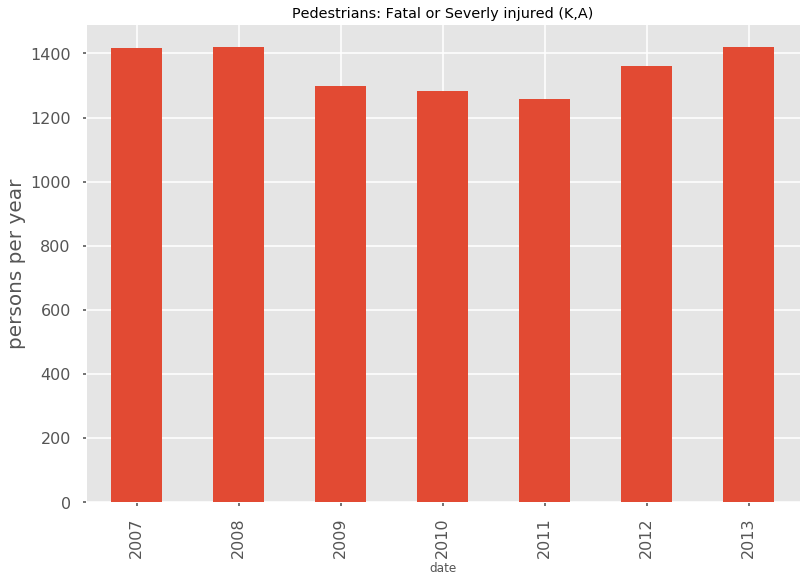

In [14]:
# number of severely injured pedestrians per year
sevInjPed.groupby(sevInjPed.date.dt.year).count()[['CS_ID']].plot(kind='bar',
                                                                 legend=False)
plt.ylabel('persons per year',fontsize=20)
plt.title('Pedestrians: Fatal or Severly injured (K,A)')

<span style="color:red"> Faraz's comment: Create a heading for the biycylists </span>

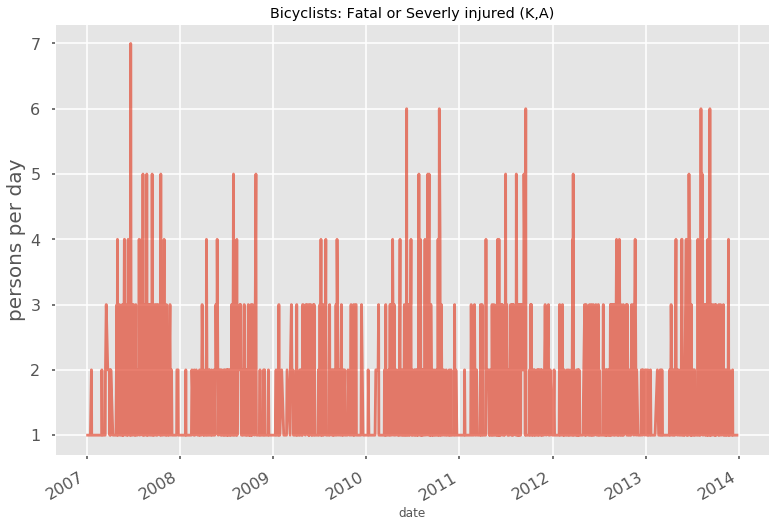

In [15]:
# number of severely injured bicyclists per day
sevInjBic = base[(base.SEVERITY.isin(['K','A']))&(base.f_Role=='bicyclist')]
sevInjBic.groupby('date').count()[['CS_ID']].plot(alpha=.7,legend=False)
plt.ylabel('persons per day',fontsize=20)
plt.title('Bicyclists: Fatal or Severly injured (K,A)')

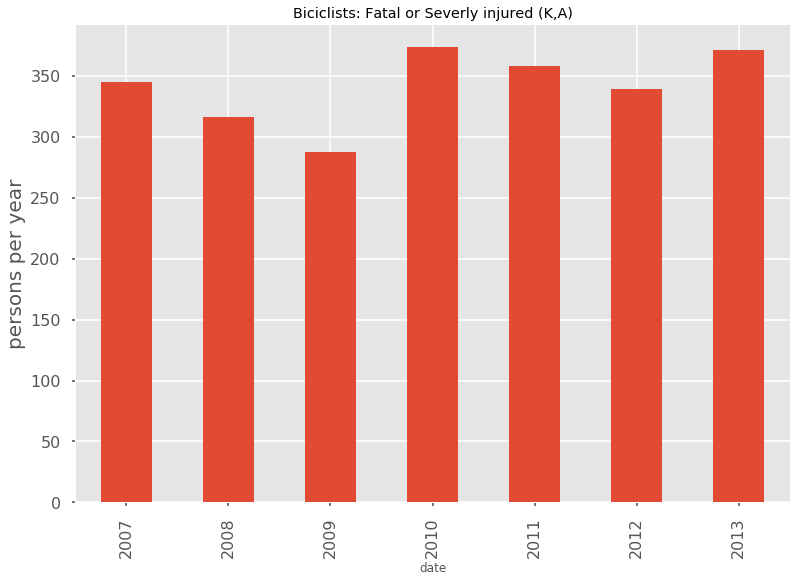

In [16]:
sevInjBic.groupby(sevInjBic.date.dt.year).count()[['CS_ID']].plot(kind='bar',
                                                                  legend=False)
plt.ylabel('persons per year',fontsize=20)
plt.title('Biciclists: Fatal or Severly injured (K,A)')

<span style="color:red"> Faraz's comment: Create a heading for the bicylists </span>

<span style="color:red"> Faraz's comment: High level thought -- the differences between the per day and per month injuries of all, pedestrians and bicyclists seem hard to get after going through these graphs. Is there a better way to capture these differences? E.g. a stacked bar chart for persons per year. </span>

Summary Numbers

In [2]:
print 'crashes per year',crashPR.shape[0]/7

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('crashes per year',crashPR.shape[0]/7)? (<ipython-input-2-d92774f96e45>, line 1)

In [18]:
kabcInjury = base[base.SEVERITY.isin(['K','A','B','C'])].CS_ID
print 'people with K, A,B, or C injuries per year',kabcInjury.shape[0]/7
print 'crashes with K, A,B, or C injuries per year',crash[(crash.CS_ID.isin(kabcInjury))].shape[0]/7

people with K, A,B, or C injuries per year 56071
crashes with K, A,B, or C injuries per year 38959


In [19]:
aInjury = base[base.SEVERITY.isin(['A'])].CS_ID
print 'people with A injuries per year',aInjury.shape[0]/7
print 'crashes with A injuries per year',crash[(crash.CS_ID.isin(aInjury))].shape[0]/7

people with A injuries per year 3581
crashes with A injuries per year 3133


In [20]:
kInjury = base[base.SEVERITY.isin(['K'])].CS_ID
print 'fatalities per year',kInjury.shape[0]/7
print 'crashes with fatalities per year',crash[(crash.CS_ID.isin(kInjury))].shape[0]/7

fatalities per year 276
crashes with fatalities per year 263


<span style="color:red"> Faraz's comment: the above summary numbers will go great with a chart. Also, what would do the explanation be? It seems intuitive that a crash will have multiple people involved hence, the crash numbers will be lower as compared to the number of people injured/dead. </span>

# Linked police and hospital data
The rest of the notebook is on the linked data. People who were able to be matched from the police report to the hospital records.

<span style="color:red"> Faraz's comment: add a summary of one to two important findings from the analysis in this section </span>

In [21]:
print 'number of people in the linked data',linked.shape[0]

number of people in the linked data 69657


In [22]:
print 'number of crashes in the linked data',linked.drop_duplicates('CS_ID').shape[0]

number of crashes in the linked data 57699


In [23]:
event = {
    1:'Other Motor Vehicle, Collision With',
    2:'Pedestrian, Collision With',
    3:'Bicyclist, Collision With'}

linked['event'] = linked.EVNTT_ID.astype(int).map(event)

linked.drop_duplicates('CS_ID').fillna('other object').groupby(['event'])\
    .count()[['CI_ID']]

,CI_ID
event,
"Bicyclist, Collision With",3651
"Other Motor Vehicle, Collision With",36622
"Pedestrian, Collision With",14262
other object,3164


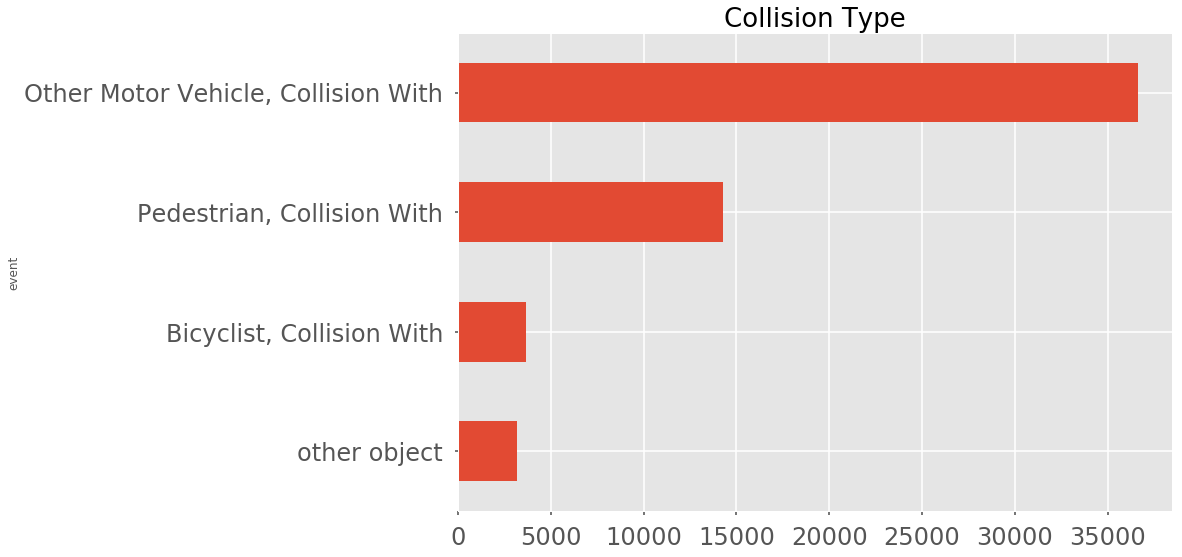

In [24]:
linked.drop_duplicates('CS_ID').fillna('other object').groupby(['event'])\
    .count()[['CI_ID']].sort_values('CI_ID').plot(kind='barh',legend=False,fontsize=24)

plt.title('Collision Type',fontsize=26)

<span style="color:red"> Faraz's comment: add the x axis title and enlarge the font size of y axis title </span>

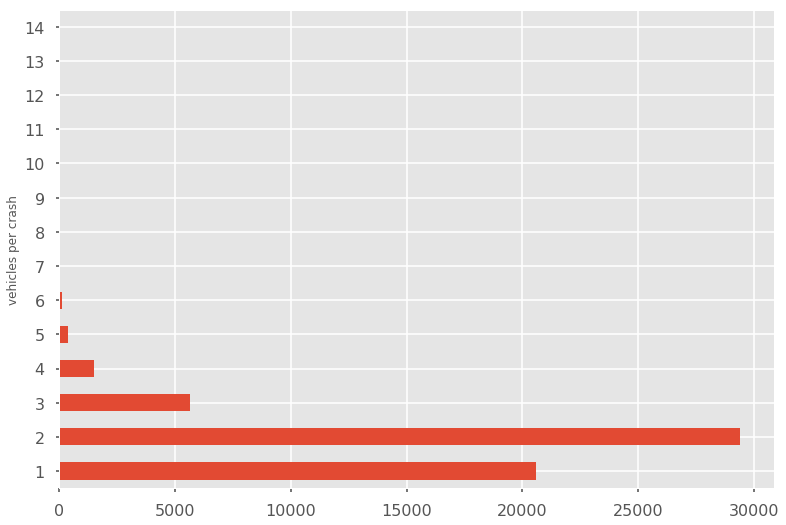

In [25]:
linked.drop_duplicates('CS_ID').groupby(linked.VEH_CNT.astype(int))\
    .count()[['CI_ID']].plot(kind='barh',legend=False)
plt.ylabel('vehicles per crash')

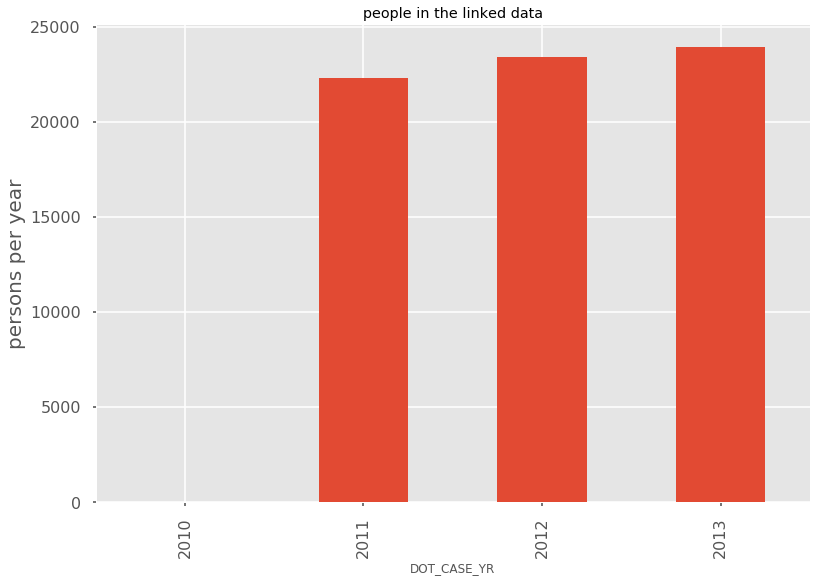

In [26]:
# linked number per year
linked.groupby('DOT_CASE_YR').count()[['CS_ID']].plot(kind='bar',legend=False)
plt.ylabel('persons per year',fontsize=20)
plt.title('people in the linked data')

In [46]:
linked.groupby('DOT_CASE_YR').count()[['CS_ID']]

,CS_ID
DOT_CASE_YR,
2010,31
2011,22291
2012,23393
2013,23942


<span style="color:red"> Faraz's comment: How come we have 31 matches for 2010? Didn't the linked data we have span from 2011 to 2013 period? </span>

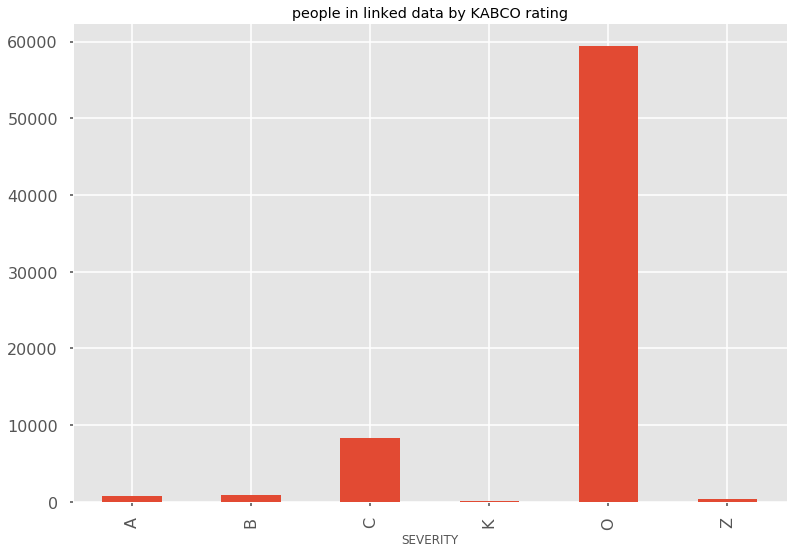

In [27]:
linked.groupby(base.SEVERITY).count()[['CS_ID']].plot(kind='bar',legend=False)
plt.title('people in linked data by KABCO rating')

## Pedestrian/bicyclist 1-vehicle -  linked data
pedestrians and bicyclists involved in one vehicle collisions in the linked dataset

In [28]:
ped[ped.CI_SEX_CDE_driver=='unknown'].groupby(ped.f_OtherVehTypeVIN).count()[['CI_ID']]

,CI_ID
f_OtherVehTypeVIN,
Bus,1
Car,340
Minivan,8
Pickup,3
SUV,88
Truck,4
Van,35
unknown,3042


In [29]:
ped[ped.CI_SEX_CDE_driver=='unknown'].groupby(ped.f_OtherVehType).count()[['CI_ID']]

,CI_ID
f_OtherVehType,
Bus,20
Car,598
Motorcycle,10
Pickup,11
Suburban,334
Truck,24
Van,64
unknown,2460


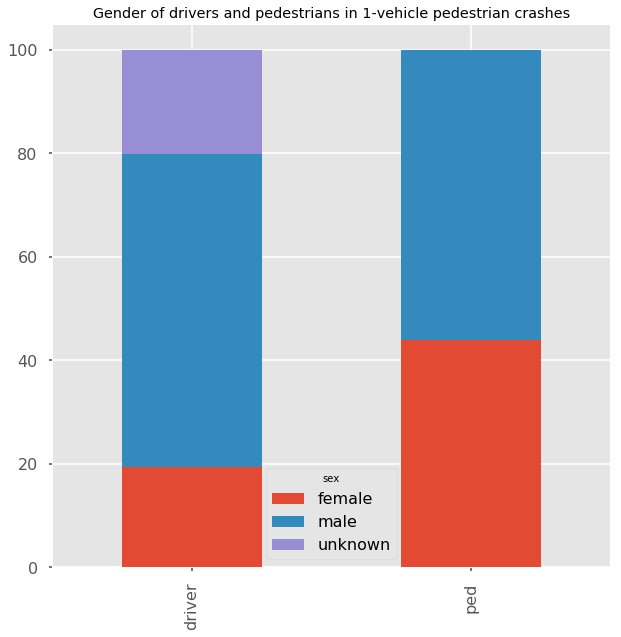

In [30]:
title = 'Gender of drivers and pedestrians in 1-vehicle pedestrian crashes'
pedSexCount = ped.groupby('f_Sex').count()[['CI_ID']]/ped.shape[0]*100
pedSexCount.columns=['ped']
pedSexCount.index.name = 'sex'

driverSexCount = ped.groupby('f_DriverSex').count()[['CI_ID']]/ped.shape[0]*100
driverSexCount.columns = ['driver']
driverSexCount.index.name = 'sex'
driverSexCount.join(pedSexCount).T.plot(kind='bar',
                                        stacked=True,
                                        figsize=(10,10),title=title)

In [31]:
driverSexCount.join(pedSexCount)#.T.plot(kind='bar',stacked=True,figsize=(10,6))

,driver,ped
sex,,
female,19.428053,43.894689
male,60.485701,56.105311
unknown,20.086246,NaN


### Severity

<span style="color:red"> Faraz's comment: again, add a summary here of one-two important findings from the analysis in this section </span>

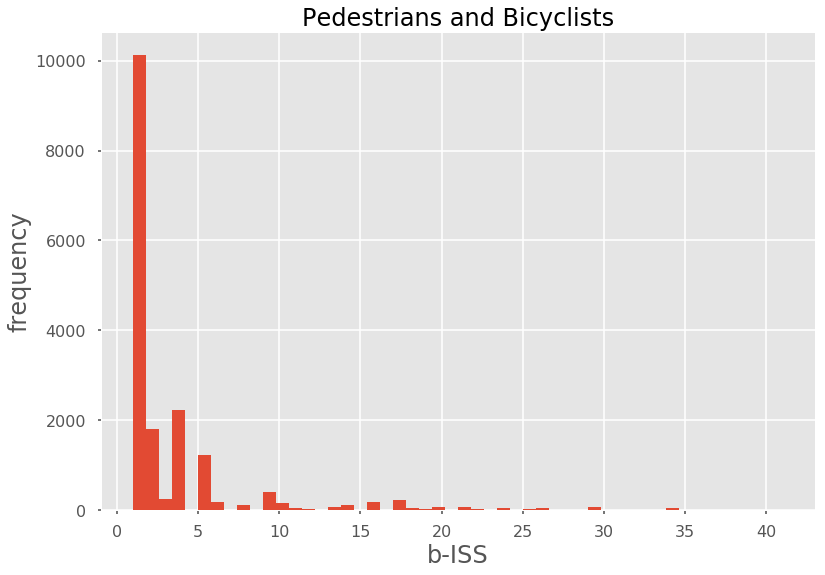

In [32]:
ped.hosp_biss.hist(bins=50)
plt.ylabel('frequency',fontsize=24)
plt.xlabel('b-ISS',fontsize=24)
plt.title('Pedestrians and Bicyclists',fontsize=24)

In [33]:
ped.shape

(17624, 106)

counts and percentage of severe
* severe = b-ISS > 8
* severe = b-ISS > 15

<span style="color:red"> Faraz's comment: I understand that an injury with b-ISS above 8 is severe but what is the injury with more than 15 b-ISS called? </span>

In [34]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,15916
True,1708


In [35]:
ped.groupby(ped.hosp_biss>8).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.903087
True,0.096913


In [36]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]

,CI_ID
hosp_biss,
False,16725
True,899


In [37]:
ped.groupby(ped.hosp_biss>15).count()[['CI_ID']]/ped.shape[0]

,CI_ID
hosp_biss,
False,0.94899
True,0.05101


KABCO rating vs b-ISS for pedestrian linked

<span style="color:red"> Faraz's comment: Embolden the heading above </span>

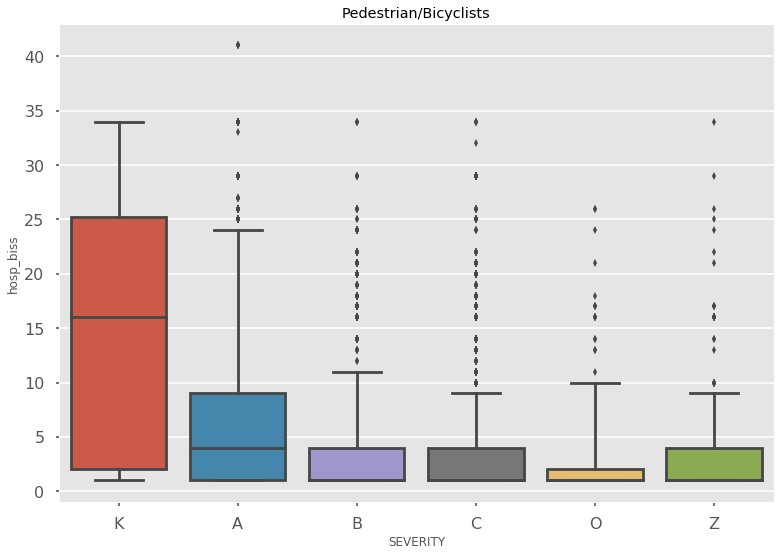

In [38]:
import seaborn as sns

sns.boxplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'], whis=[5,95]
           ).set_title('Pedestrian/Bicyclists')

<span style="color:red"> Faraz's comment: This is a very useful chart that shows a few things. It will be helpful to write out a few observations e.g. high variance in b-ISS scores among peds who're assigned K, outliers in B, C, O and Z that have high biss scores etc. </span>

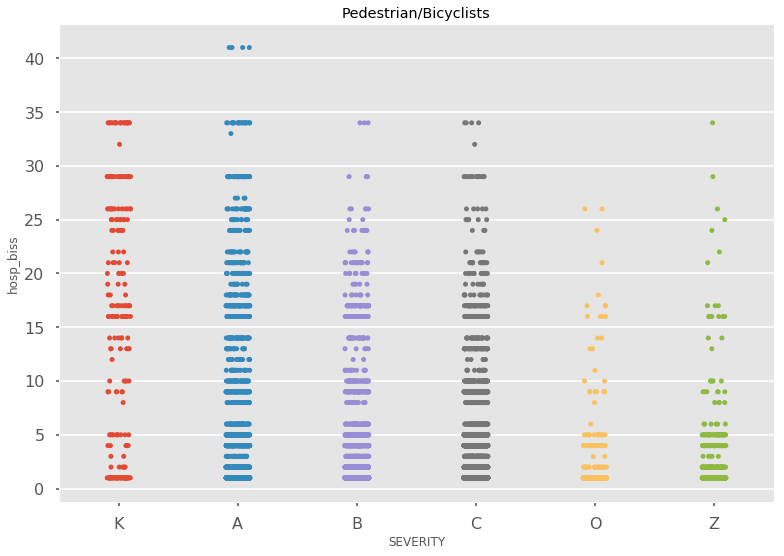

In [39]:
sns.stripplot(x='SEVERITY',y='hosp_biss',
            data=ped,order=['K','A','B','C','O','Z'],jitter=True
           ).set_title('Pedestrian/Bicyclists')

In [40]:
ped.groupby('SEVERITY').count()[['CI_ID']]

,CI_ID
SEVERITY,
A,2205
B,3890
C,10452
K,220
O,326
Z,531


In [41]:
ped['kabco'] = ped[ped.SEVERITY.isin(['B','C','O'])].SEVERITY
ped.loc[ped.SEVERITY.isin(['K','A']),'kabco']='K/A'
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


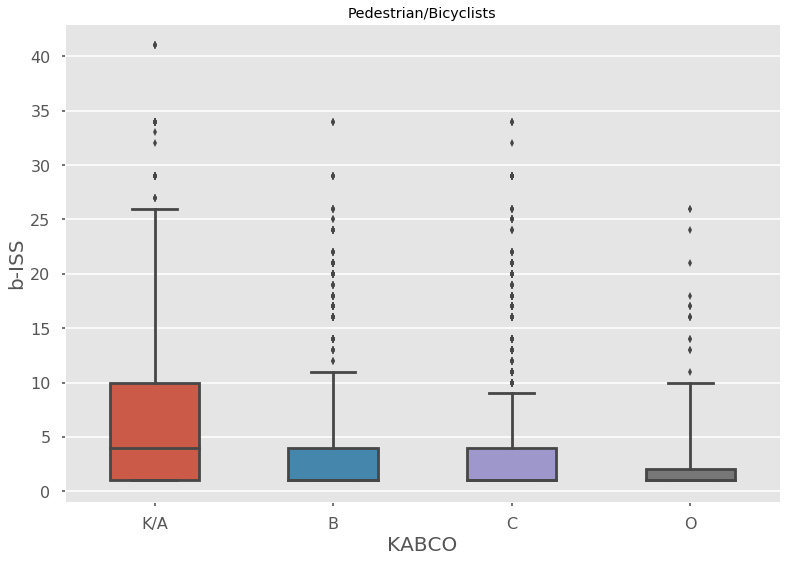

In [42]:
sns.boxplot(x='kabco',y='hosp_biss',
            data=ped,order=['K/A','B','C','O'], whis=[5,95],width=.5
           ).set_title('Pedestrian/Bicyclists')
plt.ylabel('b-ISS',fontsize=20)
plt.xlabel('KABCO',fontsize=20)

In [43]:
ped.groupby('kabco').count()[['CI_ID']]

,CI_ID
kabco,
B,3890
C,10452
K/A,2425
O,326


In [44]:
ct = pd.crosstab(ped.kabco=='K/A',ped.hosp_biss>8)
ct

hosp_biss,False,True
kabco,,
False,14240,959
True,1676,749


<span style="color:red"> Faraz's comment: Again, the table above should be explained. Why do you think there are so many false positives and false negatives? </span>

In [45]:
ped.shape[0]

17624